### Initial setup and introduction to training


In [2]:
from fastai import *
from fastai.vision import *
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from google.colab import drive

# makes Google Drive accessible to the program through the content/gdrive path
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [33]:
#opens the file called model_types and loads them in as a list

with open('/content/gdrive/MyDrive/Alzheimer_s Dataset/models/model_types.txt') as f:
  options = f.readlines()
  for i in range(len(options)):
    options[i] = options[i].rstrip('\n')

  options = sorted(options)
  print(options)

f.close()

['vgg16_bn']


In [34]:
# determines if the model has already been added to the dictionary
def isDuplicate(dictionary, key):
  if key in dictionary:
    return True
  return False

# creates the data using the file hierarchy of the Alzhimer's dataset
def prepareData(path ,valid_pct):

  # tries to create the data using the given path, if it doesn't work then prompts user to change the path and try again
  try:
    # uses the file name as the category of classes, and does not perform any transformations on the data, scales them all to 224x224px 
    # the data has 4 different categories 'MildDemented','ModerateDemented','NonDemented','VeryMildDemented' which is what the model will categorize it as
    data = ImageDataBunch.from_folder(classes = ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented'], path = IMAGE_PATH, train='train/', test='test/', valid_pct = valid_pct, ds_tfms = get_transforms(), size=224, bs=64).normalize(imagenet_stats)
    return data
  except Exception:
    return "Please check the image path"

# creates as many models as there are in the dictionary 
def create_batch_models(dictionary, data):
  model_list = []
  # iterates through all of the keys in the dictionary of models
  for item in [*dictionary]:
    print(item)

    # if the model does not exist or there is a typo, then skip creating that model
    try:
      # exec translates string into python code and runs it
      exec(dictionary[item])
      print(learn)
      model_list.append(learn)
      #print("added", item )
    except Exception:
      continue

  # outputs a list of all the models created 
  return model_list

# trains each of the models iteratively
def batch_train(model_list, num_cycles, options, MODEL_PATH):
  for i in range(len(model_list)):
    print("training " + options[i])
    # one cycle is iterating through all of the images in the training dataset, and num_cycles determines how many cycles to perform
    model_list[i].fit_one_cycle(num_cycles)
    save_weights(1, options[i], MODEL_PATH)
  

# saves the weights of the given model to a specific path
def save_weights(chkpt_num, name, MODEL_PATH):
  # sets the model directory to stated path which is where the weights file will be saved
  learn.model_dir = MODEL_PATH

  #saves the model using the words checkpoint, then the number, and dash, then the name of the model
  learn.save('checkpoint' + str(chkpt_num) + ' - ' + name)

In [35]:
model_dict = dict()

# checks if the model has already been added to the dictionary; if not, then adds the name of the model as the key, and the code to create the model as the value
for item in options:
  if(not isDuplicate(model_dict,item)):
    # the string creates the specific model with the validation metrics of error rate and accuracy, and has a weight decay of 1e-1 which will allow the model to better hit the absolute minimum error
    model_dict[item] = 'learn = cnn_learner(data, models.' + item + ', metrics=[error_rate, accuracy], wd=1e-1, callback_fns=ShowGraph)'

print([*model_dict])
print(model_dict)

['vgg16_bn']
{'vgg16_bn': 'learn = cnn_learner(data, models.vgg16_bn, metrics=[error_rate, accuracy], wd=1e-1, callback_fns=ShowGraph)'}


In [36]:
# if the dataset is uploaded straight to drive, this should stay the same
IMAGE_PATH = Path('/content/gdrive/MyDrive/Alzheimer_s Dataset/')

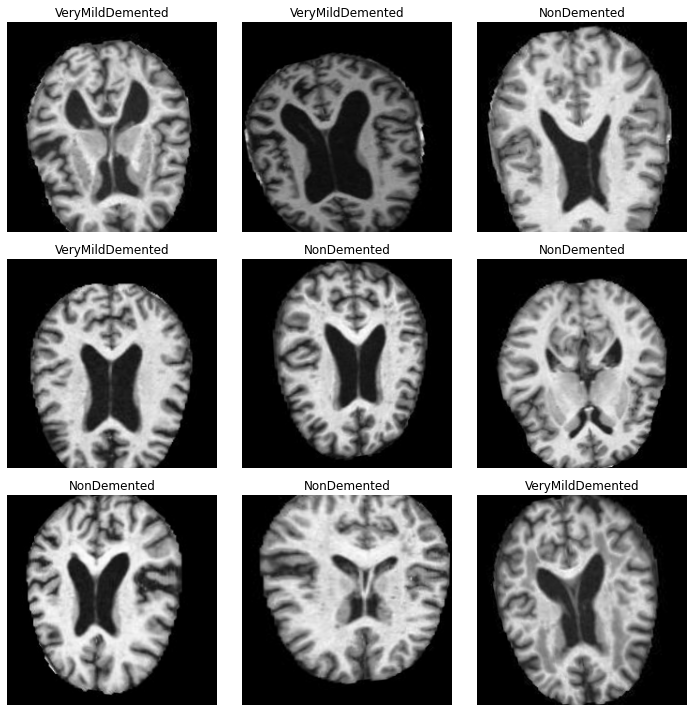

In [37]:
# calls the above prepareData function with using 0.4 of the data as validation 
data = prepareData(IMAGE_PATH, 0.4)

# checks if data has been created correctly, if not then prints the prompt to check the image path
if(data != "Please check the image path"):
  data.show_batch(rows=3, figsize=(10,10))
else:
  print(data)

In [38]:
# sets the path of where to save and load the model to
MODEL_PATH = Path('/content/gdrive/MyDrive/Alzheimer_s Dataset/checkpoints')

# calls the create_batch_models function defiend above and sets them to a variable (output of the function is a list)
created_models = create_batch_models(model_dict, data)
print(created_models)

vgg16_bn
Learner(data=ImageDataBunch;

Train: LabelList (3073 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
ModerateDemented,ModerateDemented,ModerateDemented,ModerateDemented,ModerateDemented
Path: /content/gdrive/MyDrive/Alzheimer_s Dataset;

Valid: LabelList (2048 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
VeryMildDemented,NonDemented,VeryMildDemented,NonDemented,NonDemented
Path: /content/gdrive/MyDrive/Alzheimer_s Dataset;

Test: LabelList (1279 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /content/gdrive/MyDrive/Alzheimer_s Dataset, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-

training vgg16_bn


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.505399,1.012868,0.481445,0.518555,04:54
1,1.319510,0.909218,0.397461,0.602539,01:02
2,1.189552,0.872892,0.441406,0.558594,01:01
3,1.072575,0.853503,0.389648,0.610352,01:02
4,0.999350,0.815401,0.391113,0.608887,01:02


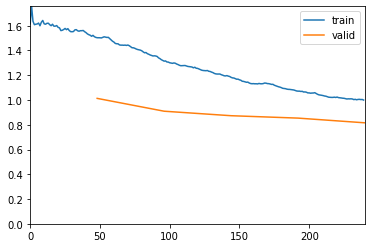

In [41]:
# trains all of the models using 5 loops through the dataset
batch_train(created_models, 5, options, MODEL_PATH)

### Full scale training

In [42]:
# sets the model to the given weights loaded form the MODEL_PATH path using the same naming convention as how it was saved
def load_weights(chkpt_num, name, MODEL_PATH):
  learn.model_dir = MODEL_PATH
  learn.load('checkpoint' + str(chkpt_num) + ' - ' + name)

# retrains the model for the second time and sets the outputs to another file but this time checkpoint2
def custom_train(model_list, num_cycles, options, MODEL_PATH):
  for i in range(len(model_list)):
    print("training " + options[i])

    # unfreeze allows all of the weights from all of the layers of the model to be retrained
    model_list[i].unfreeze()

    # sets a max learning rate to prevent the model from jumping over the absolute minimum. uses the slice to first use one then the other to increases chances of finding the minimum
    model_list[i].fit_one_cycle(num_cycles, max_lr=slice(1e-6,3e-4))

    # saves the weights using the previous mentioned naming conventions
    save_weights(2, options[i], MODEL_PATH)

In [44]:
# creates data again but this time with only 0.2 used for validation. Less is used to allow the model to train more thoroughly since this is a complete train whereas the previous one was a sample train
data = prepareData(IMAGE_PATH, 0.2)

vgg16_bn
Learner(data=ImageDataBunch;

Train: LabelList (3073 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
ModerateDemented,ModerateDemented,ModerateDemented,ModerateDemented,ModerateDemented
Path: /content/gdrive/MyDrive/Alzheimer_s Dataset;

Valid: LabelList (2048 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
VeryMildDemented,NonDemented,VeryMildDemented,NonDemented,NonDemented
Path: /content/gdrive/MyDrive/Alzheimer_s Dataset;

Test: LabelList (1279 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /content/gdrive/MyDrive/Alzheimer_s Dataset, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.951216,0.813756,0.393066,0.606934,01:01
1,0.940237,0.812087,0.391602,0.608398,01:02
2,0.945586,0.824467,0.398438,0.601562,01:02
3,0.921034,0.804737,0.371582,0.628418,01:02
4,0.918156,0.825271,0.391113,0.608887,01:02
5,0.912276,0.825682,0.389648,0.610352,01:02
6,0.910182,0.779719,0.372559,0.627441,01:02
7,0.884258,0.796022,0.385254,0.614746,01:02
8,0.868449,0.748002,0.360352,0.639648,01:02
9,0.853452,0.741024,0.359863,0.640137,01:03


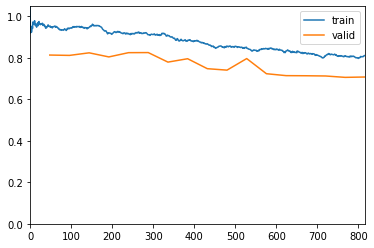

In [45]:
# loops through the keys in model_dict
for item in [*model_dict]:
  # if item does not exist or there is an error then skip to next item
  try:
    # changes the values of each key to a previous command + a pretrained=False which means we are completely overwriting all the training (complete custom training)
    model_dict[item] = 'learn = cnn_learner(data, models.' + item + ', pretrained=False, metrics=[error_rate, accuracy], wd=1e-1, callback_fns=ShowGraph)'
  except Exception:
    continue

# create a list of the models using the previous commands
full_scale_models = create_batch_models(model_dict, data)
for i in range(len(full_scale_models)):
  # loads in the weights from the checkpoint
  load_weights(1, options[i], MODEL_PATH)

  # run following code to determine most optimal learning rates for model 
  #learn.lr_find()
  #learn.recorder.plot()

  # trains all models using 17 loops through the whole data
  custom_train(full_scale_models, 17, options, MODEL_PATH)


### Validation/Testing


In [ ]:
# create a test data with mostly validation images since we are trying to test the accuracy
test_data = prepareData(IMAGE_PATH, 0.95)

for i in range(len(full_scale_models)):
  # evaluates each model using the error rate and FBeta metrics. the FBeta metric averages the precision and recall score of the model (can by synonymously thought of as accuracy) 
  ev = full_scale_models[i].validate(test_data.train_dl,metrics=[error_rate, FBeta(average='weighted')])

  # creates a matrix for how many the model identified correctly and how many it identified incorrectly (the square where the x and y axis are the same means it identified it correctly)
  interp = ClassificationInterpretation.from_learner(full_scale_models[i])
  interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

  # prints the error and accuracy scores
  print("The test data's output for " + options[i] + " is: \nError rate", float(ev[1]), "\nAccuracy", float(ev[2]))

### User uploaded image

In [8]:
from google.colab import files

In [11]:
# taken from the Google Colab code snippets function which allows users to upload a file from their computer 
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving model_types.txt to model_types.txt
User uploaded file "model_types.txt" with length 25 bytes


In [ ]:
# checks if the file extension of the uploaded image is a jpg. If it is, then opens the image
if(fn.split('.')[1] == 'jpg'):
  img = open_image('/content/' + fn)
else:
  print("Please upload a jpg image")

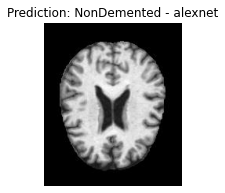

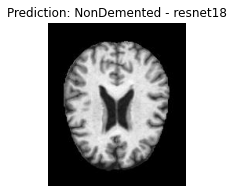

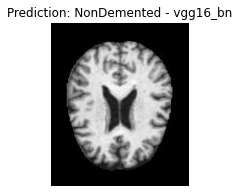

In [31]:
for i in range(len(full_scale_models)): 
  # feeds the image into each of the models and predicts it to one of the 4 classes
  pred_class, pred_idx, outputs = full_scale_models[i].predict(img)

  #plots the image with the title having the prediction
  img.show(title= "Prediction: " + full_scale_models[i].data.classes[to_data(pred_class)] + ' - ' + options[i])